# Matchers notebook

In [68]:
import psycopg2

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)
import plotly.express as px

from dotenv import load_dotenv
load_dotenv();

In [2]:
conn = psycopg2.connect( host= os.environ.get('DB_HOST'),
                         database= os.environ.get('DB_NAME'), 
                        user= os.environ.get('DB_USER'), 
                        password= os.environ.get('DB_PASSWORD'), 
                        port= os.environ.get('DB_PORT'))

cursor = conn.cursor()
progression_table = pd.read_sql_query('select * from progression_data',con=conn)
progression_table.sort_values(by='timestamp',inplace=True,ascending=False)

# Percent of users left the first level

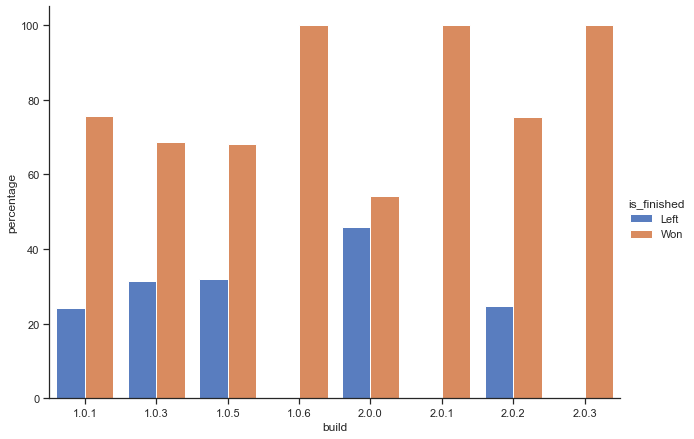

In [3]:
bulid_finished_first = progression_table[progression_table.level_index == 0].groupby(['build', 'is_finished']).agg({'user_id':'count'})
build_first = progression_table[progression_table.level_index == 0].groupby('build').agg({'user_id': 'count'})
build_finished_percent_first = (bulid_finished_first.div(build_first, level='build') * 100).reset_index().rename(columns={'user_id':'percentage'}).sort_values(by='build',ascending=True)
build_finished_percent_first = build_finished_percent_first[build_finished_percent_first.build != ""]
# sns.set(rc={'figure.figsize':(100,8.27)})
ax = sns.catplot(x="build", y="percentage", hue="is_finished", kind="bar",
 data=build_finished_percent_first,height=6.27, aspect=11.7/8.27, palette="muted")

# Participation in each level percent

In [192]:
level_data =  progression_table.drop_duplicates(subset=['user_id', 'level'])[['user_id','build','level_index','is_finished']]

players_won_in_each_level = level_data[(level_data.is_finished == 'Won') & (level_data.build != '')].groupby(['build', 'level_index']).agg({'user_id':'count'})
players_in_each_level = level_data[level_data.build != ''].groupby(['build', 'level_index']).agg({'user_id':'count'})

participation_percent = players_in_each_level.divide(players_won_in_each_level.groupby(level= 0).shift(1)).reset_index()

bool_cond = participation_percent.user_id > 1
participation_percent.loc[bool_cond, 'user_id'] = 1


<AxesSubplot:xlabel='level_index', ylabel='user_id'>

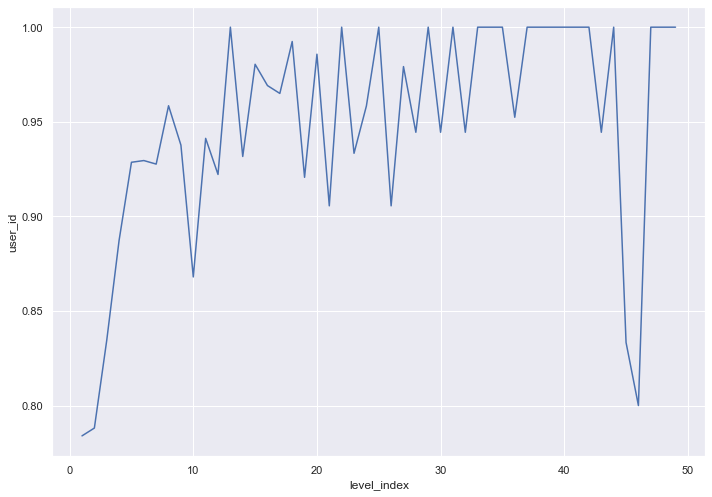

In [205]:
all_participation = participation_percent.groupby('level_index').agg({'user_id':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data = all_participation, 
        x="level_index", 
        y="user_id", 
        # height=6.27, aspect=11.7/8.27
        )

In [198]:
px.line(participation_percent[participation_percent.level_index < 11], 
        x="level_index", 
        y="user_id", 
        color="build",
        )